#  What is K-means?

K-means clustering is an unsupervised clustering technique that assigns data points into groups based on distance. By using the K-means algorithm on a dataset, you can create labels for given data points as well as understand features of labels.

K-means is part of the **Expectation Maximization** algorithm family, and is a special case of Gaussian Mixture Models where covariance and variance are not taken into account.

K-means also uses hard clustering- we are assigning a label to a given data point vs a distribution of probabilities (GMM).

Why use K-means?
1. Fairly easy and quick to use/implement, uses Euclidean distances to find similarities
2. Good for segmentation, anomaly detection, object categorization 
3. Centroids are relatively interpretable as they are just the mean values of its labeled data points
4. We can use k-means clustering for feature engineering/dimensionality reduction

Where does K-means fall short? 
1. K-means implies a spherical cluster, as it uses Euclidean Distance to group data points
2. K-means requires a specified number of clusters at initiation
3. Heavily influenced by outliers on the dataset (Can be countered by K-medians clustering)
4. Depending on Centroid initialization, K-means will have different solutions.
5. Hard clustering may lead to mislabeled data points.
   

Kmeans is an iterative process that follows the following process:  
**Setup**    
    1. Pick *k*-random points in the feature space. We will call these points "centroids".  
**Assign Labels**  
    2. For each point in the dataset, calcuate the Euclidean distance from each point to each centroid. From these cluster distances, assign a label (*0,1,2,...k*) to the data point where the distance between the data point and the centroid is the shortest.  
**Update Centroids**  
    3. Now that each label has a "cluster" of data points, we sum the distances for each data point to its corresponding label. This is known as _inertia_ or _distortion_, and we are now going to try to minimize this score going forward.
    4. We then take the average each feature across the datapoints and move the centroid to that average in the feature space.
    5. Repeat steps 2-4 until _inertia_ does not deviate from the previous iteration by a predetermined margin, or by a predetermined number of iterations.

Let's try to build the K-means algorithm from scratch, using the Iris Dataset. We will then compare the clustering results from K-means to actual labels from the dataset.

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score
%pylab inline

link = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df=pd.read_csv(link,header=None)
data=df.drop(columns=[4])
data=data.as_matrix()
df.head()

Populating the interactive namespace from numpy and matplotlib


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Let's write a distance function instead of importing pairwise distance function.

In [107]:
def euclideanDistance(x1,x2,axis):
    return np.sum((x1-x2)**2,axis=axis)

In [111]:
from copy import deepcopy
class Kmeans():
    def __init__(self,k):
        self.k = k
        self.margin=0.0001 #sci-kit learn 
        self.inertia=[]
        
    def fit(self,data):
        '''Initialize k centroids'''
        centroids= data[np.random.choice(len(data),self.k,replace=False)] 
        margin=1 # set an arbitrary margin that we will continuously update until margin falls below our specified number
        
        while margin>self.margin:
            distances=np.array([euclideanDistance(data,y,1) for y in centroids]).T #calculate all distances to centroids
            cluster_label=np.argmin(distances,axis=1) #assign cluster labels through shortest distance
            inertia_score= sum([euclideanDistance(feat,centroids[cluster_label[i]],0) for i, feat in enumerate(data)])
            self.inertia.append(inertia_score)
            centroids_old = deepcopy(centroids)#create a copy of centroids to compare difference
            for i in range(self.k):
                points=[y for index,y in enumerate(data) if cluster_label[index]==i]
                centroids[i]= np.mean(points,axis=0) #update new centroids
            margin=sum(euclideanDistance(centroids_old,centroids,0)) #update margin and proceed to next iteration if applicable
        
        self.centroids=centroids
        self.cluster_label=cluster_label
    def centroids(self):
        return self.centroids
    def inertia(self):
        return self.inertia
    def clusters(self):
        return self.cluster_label
    def SSE(self):
        return(self.inertia[-1])

Let's test the inertia as we go through multiple iterations:  
SSE starts approaching its minimum after 6 iterations.

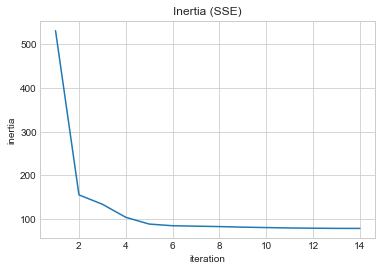

In [114]:
f=Kmeans(3)
f.fit(data)
plt.plot(range(1,len(x.inertia)+1),x.inertia)
plt.title("Inertia (SSE)")
plt.xlabel("iteration")
plt.ylabel("inertia");


How do we know which *k*-value is appropriate? We can plot the SSE's over a given range of *k* and find a value of *k* where there is a steep change or elbow. In this case, 3 seems more than appropriate.  

We can also use a **silhouette_score** to properly identify k-values. Typically, the closer a silhouette score score is to 1, the more resolved a cluster is. In this case, we don't see anything special, but a *k* value of 3 has a decently high score. We can then conclude that a 3 cluster model is the most appropriate given the dataset.

In [117]:
k_iters=range(2,7)
SSE=[]
silh=[]
for i in k_iters:
    x=Kmeans(i)
    x.fit(data)
    SSE.append(x.SSE())
    silh.append(silhouette_score(data,x.clusters()))

Text(0,0.5,'Silhouette Score')

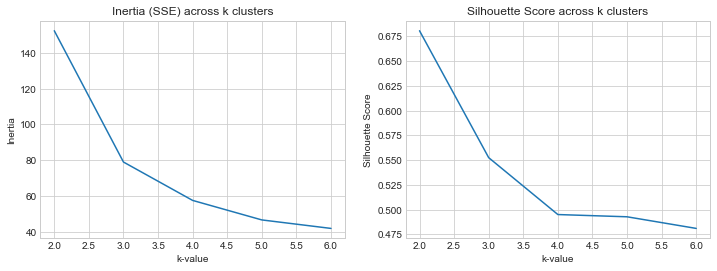

In [118]:

sns.set_style("whitegrid")
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(range(2,len(SSE)+2),SSE)
plt.title("Inertia (SSE) across k clusters")
plt.xlabel("k-value")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(range(2,len(silh)+2),silh)
plt.title("Silhouette Score across k clusters")
plt.xlabel("k-value")
plt.ylabel("Silhouette Score")

Now that we have established a proper *k* value, let's plug it into our Kmeans model and visualize the clusters.

In [127]:
x=Kmeans(3)
x.fit(data)
df['class']=x.clusters()
df.columns=['slength','swidth','plength','pwidth','label','cluster']

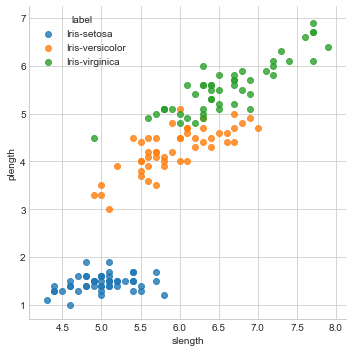

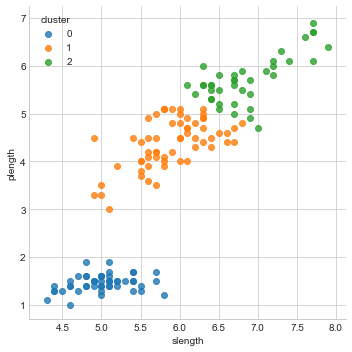

In [128]:
plt.figure(figsize=(6,6))
sns.lmplot(data=df ,x='slength', y='plength',hue='label',
                   fit_reg=False, legend=True, legend_out=False)

sns.lmplot(data=df ,x='slength', y='plength',hue='cluster',
                   fit_reg=False, legend=True, legend_out=False)

Just for fun, lets see how close our unsupervised labels match the actual classification

In [129]:
label_dict= {'Iris-setosa':0,'Iris-virginica':2,'Iris-versicolor':1}

In [130]:
df['cluster_label']=[label_dict.get(x) for x in df.label]
accuracy=numpy.sum(df.cluster_label==df.cluster)/len(df)

In [131]:
accuracy

0.8866666666666667

Not Bad for some unsupervised Learning! Lets see how it fares against sklearn's Kmeans:

In [132]:
from sklearn.cluster import KMeans
z=KMeans(3)

In [133]:
z.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [134]:
z.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

In [135]:
df['SKL']=z.labels_

In [136]:
sklabel_dict= {1:0,2:1,0:2}

In [137]:
df['SKL']=[sklabel_dict.get(x) for x in df.SKL]

In [138]:
accuracy=numpy.sum(df.cluster_label==df.SKL)/len(df)

In [139]:
accuracy

0.8933333333333333